In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import os
from datetime import datetime
import warnings
import gzip
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

np.random.seed(42)

In [ ]:
directories = [
    'data/raw',
    'data/processed',
    'data/interim',
    'models',
    'outputs',
    'logs'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

In [ ]:
BASE_URL = "https://fakestoreapi.com"

def fetch_all_products():
    """
    Fetch all products from FakeStoreAPI
    """
    try:
        response = requests.get(f"{BASE_URL}/products")
        response.raise_for_status()
        products = response.json()
        print(f" Successfully fetched {len(products)} products")
        return products
    except requests.exceptions.RequestException as e:
        print(f" Error fetching products: {e}")
        return []

products_data = fetch_all_products()

if products_data:
    print("\nSample Product:")
    print(json.dumps(products_data[0], indent=2))

 Successfully fetched 20 products

Sample Product:
{
  "id": 1,
  "title": "Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops",
  "price": 109.95,
  "description": "Your perfect pack for everyday use and walks in the forest. Stash your laptop (up to 15 inches) in the padded sleeve, your everyday",
  "category": "men's clothing",
  "image": "https://fakestoreapi.com/img/81fPKd-2AYL._AC_SL1500_t.png",
  "rating": {
    "rate": 3.9,
    "count": 120
  }
}


In [ ]:
def fetch_categories():
    """
    Fetch all product categories from FakeStoreAPI
    """
    try:
        response = requests.get(f"{BASE_URL}/products/categories")
        response.raise_for_status()
        categories = response.json()
        print(f" Successfully fetched {len(categories)} categories")
        return categories
    except requests.exceptions.RequestException as e:
        print(f" Error fetching categories: {e}")
        return []

categories_data = fetch_categories()
print(f"\nAvailable Categories: {categories_data}")

 Successfully fetched 4 categories

Available Categories: ['electronics', 'jewelery', "men's clothing", "women's clothing"]


In [ ]:
df_products = pd.DataFrame(products_data)

if 'rating' in df_products.columns:
    df_products['rating_rate'] = df_products['rating'].apply(lambda x: x.get('rate', None) if isinstance(x, dict) else None)
    df_products['rating_count'] = df_products['rating'].apply(lambda x: x.get('count', None) if isinstance(x, dict) else None)
    df_products = df_products.drop('rating', axis=1)

print(f"Products DataFrame Shape: {df_products.shape}")
print(f"\nColumns: {df_products.columns.tolist()}")
print("\nFirst few rows:")
df_products.head()

Products DataFrame Shape: (20, 8)

Columns: ['id', 'title', 'price', 'description', 'category', 'image', 'rating_rate', 'rating_count']

First few rows:


,id,title,price,description,category,image,rating_rate,rating_count
0,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",109.95,Your perfect pack for everyday use and walks i...,men's clothing,https://fakestoreapi.com/img/81fPKd-2AYL._AC_S...,3.9,120
1,2,Mens Casual Premium Slim Fit T-Shirts,22.30,"Slim-fitting style, contrast raglan long sleev...",men's clothing,https://fakestoreapi.com/img/71-3HjGNDUL._AC_S...,4.1,259
2,3,Mens Cotton Jacket,55.99,great outerwear jackets for Spring/Autumn/Wint...,men's clothing,https://fakestoreapi.com/img/71li-ujtlUL._AC_U...,4.7,500
3,4,Mens Casual Slim Fit,15.99,The color could be slightly different between ...,men's clothing,https://fakestoreapi.com/img/71YXzeOuslL._AC_U...,2.1,430
4,5,John Hardy Women's Legends Naga Gold & Silver ...,695.00,"From our Legends Collection, the Naga was insp...",jewelery,https://fakestoreapi.com/img/71pWzhdJNwL._AC_U...,4.6,400


In [ ]:
df_products.to_csv('data/raw/fakestore_products.csv', index=False)

with open('data/raw/fakestore_categories.json', 'w') as f:
    json.dump(categories_data, f, indent=2)

In [ ]:
def generate_user_interactions(n_users=500, n_interactions=5000):
    """
    Generate simulated user interaction data with realistic patterns
    
    Parameters:
    - n_users: Number of unique users
    - n_interactions: Total number of interactions to generate
    """
    np.random.seed(42)
    
    interaction_types = ['view', 'click', 'add_to_cart', 'purchase']
    interaction_weights = [0.5, 0.3, 0.15, 0.05]
    
    interactions = []
    
    for _ in range(n_interactions):
        user_id = np.random.randint(1, n_users + 1)
        product_id = np.random.choice(df_products['id'].values)
        interaction_type = np.random.choice(interaction_types, p=interaction_weights)
        
        days_ago = np.random.randint(0, 90)
        hours = np.random.randint(0, 24)
        minutes = np.random.randint(0, 60)
        timestamp = datetime.now() - pd.Timedelta(days=days_ago, hours=hours, minutes=minutes)
        
        if interaction_type == 'view':
            duration = np.random.randint(5, 60)
        elif interaction_type == 'click':
            duration = np.random.randint(30, 180)
        elif interaction_type == 'add_to_cart':
            duration = np.random.randint(60, 300)
        else:
            duration = np.random.randint(120, 600)
        
        interactions.append({
            'user_id': user_id,
            'product_id': product_id,
            'interaction_type': interaction_type,
            'timestamp': timestamp,
            'duration_seconds': duration
        })
    
    df_interactions = pd.DataFrame(interactions)
    df_interactions = df_interactions.sort_values('timestamp').reset_index(drop=True)
    
    print(f" Generated {len(df_interactions)} user interactions")
    print(f" Unique users: {df_interactions['user_id'].nunique()}")
    print(f" Unique products: {df_interactions['product_id'].nunique()}")
    
    return df_interactions

df_interactions = generate_user_interactions(n_users=500, n_interactions=5000)

print("\nInteraction Type Distribution:")
print(df_interactions['interaction_type'].value_counts())

print("\nSample Interactions:")
df_interactions.head(10)

 Generated 5000 user interactions
 Unique users: 500
 Unique products: 20

Interaction Type Distribution:
interaction_type
view           2462
click          1511
add_to_cart     769
purchase        258
Name: count, dtype: int64

Sample Interactions:


,user_id,product_id,interaction_type,timestamp,duration_seconds
0,327,7,view,2025-09-09 03:14:42.804059,44
1,218,2,view,2025-09-09 04:20:42.758690,36
2,276,16,purchase,2025-09-09 04:20:42.779394,181
3,393,17,click,2025-09-09 04:51:42.845207,106
4,110,13,view,2025-09-09 05:10:42.778246,28
5,393,20,click,2025-09-09 05:26:42.751831,43
6,167,20,view,2025-09-09 05:42:42.815503,32
7,21,17,purchase,2025-09-09 06:02:42.787203,568
8,337,9,add_to_cart,2025-09-09 06:20:42.759997,136
9,212,16,view,2025-09-09 06:56:42.818148,55


In [ ]:
df_interactions.to_csv('data/raw/user_interactions.csv', index=False)

In [ ]:
AMAZON_DATASETS = {
    'electronics': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz',
    'electronics_meta': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz'
}

def download_file(url, output_path):
    """
    Download a file from URL with progress bar
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        
        with open(output_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=os.path.basename(output_path)) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
        
        print(f" Downloaded: {output_path}")
        return True
    except Exception as e:
        print(f" Error downloading {url}: {e}")
        return False

# Download reviews
reviews_path = 'data/raw/amazon_electronics_reviews.json.gz'
if not os.path.exists(reviews_path):
    download_file(AMAZON_DATASETS['electronics'], reviews_path)
else:
    print(f" Reviews file already exists: {reviews_path}")

# Download metadata
meta_path = 'data/raw/amazon_electronics_meta.json.gz'
if not os.path.exists(meta_path):
    download_file(AMAZON_DATASETS['electronics_meta'], meta_path)
else:
    print(f" Metadata file already exists: {meta_path}")

Starting Amazon SNAP dataset download...
Note: This may take several minutes depending on your connection.



amazon_electronics_reviews.json.gz: 100%|██████████| 496M/496M [07:45<00:00, 1.07MB/s]   


 Downloaded: data/raw/amazon_electronics_reviews.json.gz


amazon_electronics_meta.json.gz: 100%|██████████| 187M/187M [02:59<00:00, 1.04MB/s] 

 Downloaded: data/raw/amazon_electronics_meta.json.gz


In [ ]:
import gzip
reviews_path = 'data/raw/amazon_electronics_reviews.json.gz'
meta_path = 'data/raw/amazon_electronics_meta.json.gz'

def parse_amazon_json(path, n_samples=1000):
    """
    Parse Amazon JSON.gz file and return first n_samples
    """
    data = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= n_samples:
                break
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError:
                continue
    return data

if os.path.exists(reviews_path):
    print("Loading sample Amazon reviews...")
    sample_reviews = parse_amazon_json(reviews_path, n_samples=1000)
    df_amazon_reviews = pd.DataFrame(sample_reviews)
    
    print(f"\nLoaded {len(df_amazon_reviews)} sample reviews")
    print(f"Columns: {df_amazon_reviews.columns.tolist()}")
    print("\nSample Review:")
    display(df_amazon_reviews.head(3))
else:
    print("Amazon reviews file not found. Please run the download cell above.")

Loading sample Amazon reviews...

Loaded 1000 sample reviews
Columns: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']

Sample Review:


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"


In [ ]:
import ast

def parse_amazon_metadata(path, n_samples=1000):
    """
    Parse Amazon metadata file (Python dict format).
    """
    data = []
    with gzip.open(path, 'rt', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if i >= n_samples:
                break
            try:
                data.append(ast.literal_eval(line.strip()))
            except (ValueError, SyntaxError):
                continue
    return data

In [11]:
sample_meta = parse_amazon_metadata(meta_path, n_samples=1000)
df_amazon_meta = pd.DataFrame(sample_meta)
df_amazon_meta.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [13]:
print(f"\nTotal Products: {len(df_products)}")
print(f"\nCategories Distribution:")
print(df_products['category'].value_counts())


Total Products: 20

Categories Distribution:
category
electronics         6
women's clothing    6
men's clothing      4
jewelery            4
Name: count, dtype: int64


In [14]:
print(f"\nPrice Statistics:")
print(df_products['price'].describe())


Price Statistics:
count     20.000000
mean     162.046000
std      272.220532
min        7.950000
25%       15.240000
50%       56.490000
75%      110.962500
max      999.990000
Name: price, dtype: float64


In [15]:
print(f"\nRating Statistics:")
if 'rating_rate' in df_products.columns:
    print(df_products['rating_rate'].describe())


Rating Statistics:
count    20.000000
mean      3.560000
std       0.961578
min       1.900000
25%       2.900000
50%       3.700000
75%       4.525000
max       4.800000
Name: rating_rate, dtype: float64


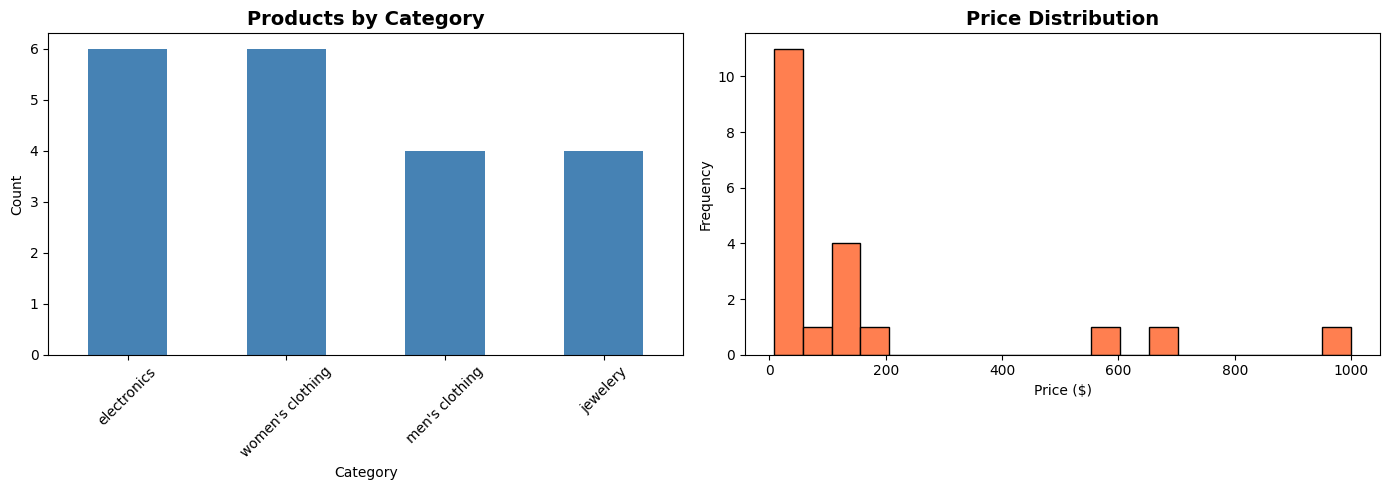

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category distribution
df_products['category'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Products by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Price distribution
axes[1].hist(df_products['price'], bins=20, color='coral', edgecolor='black')
axes[1].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
print(f"\nTotal Interactions: {len(df_interactions)}")
print(f"Unique Users: {df_interactions['user_id'].nunique()}")
print(f"Unique Products: {df_interactions['product_id'].nunique()}")


Total Interactions: 5000
Unique Users: 500
Unique Products: 20


In [18]:
print(f"\nInteraction Type Distribution:")
print(df_interactions['interaction_type'].value_counts())


Interaction Type Distribution:
interaction_type
view           2462
click          1511
add_to_cart     769
purchase        258
Name: count, dtype: int64


In [19]:
print(f"\nAverage Interactions per User: {len(df_interactions) / df_interactions['user_id'].nunique():.2f}")
print(f"Average Interactions per Product: {len(df_interactions) / df_interactions['product_id'].nunique():.2f}")


Average Interactions per User: 10.00
Average Interactions per Product: 250.00


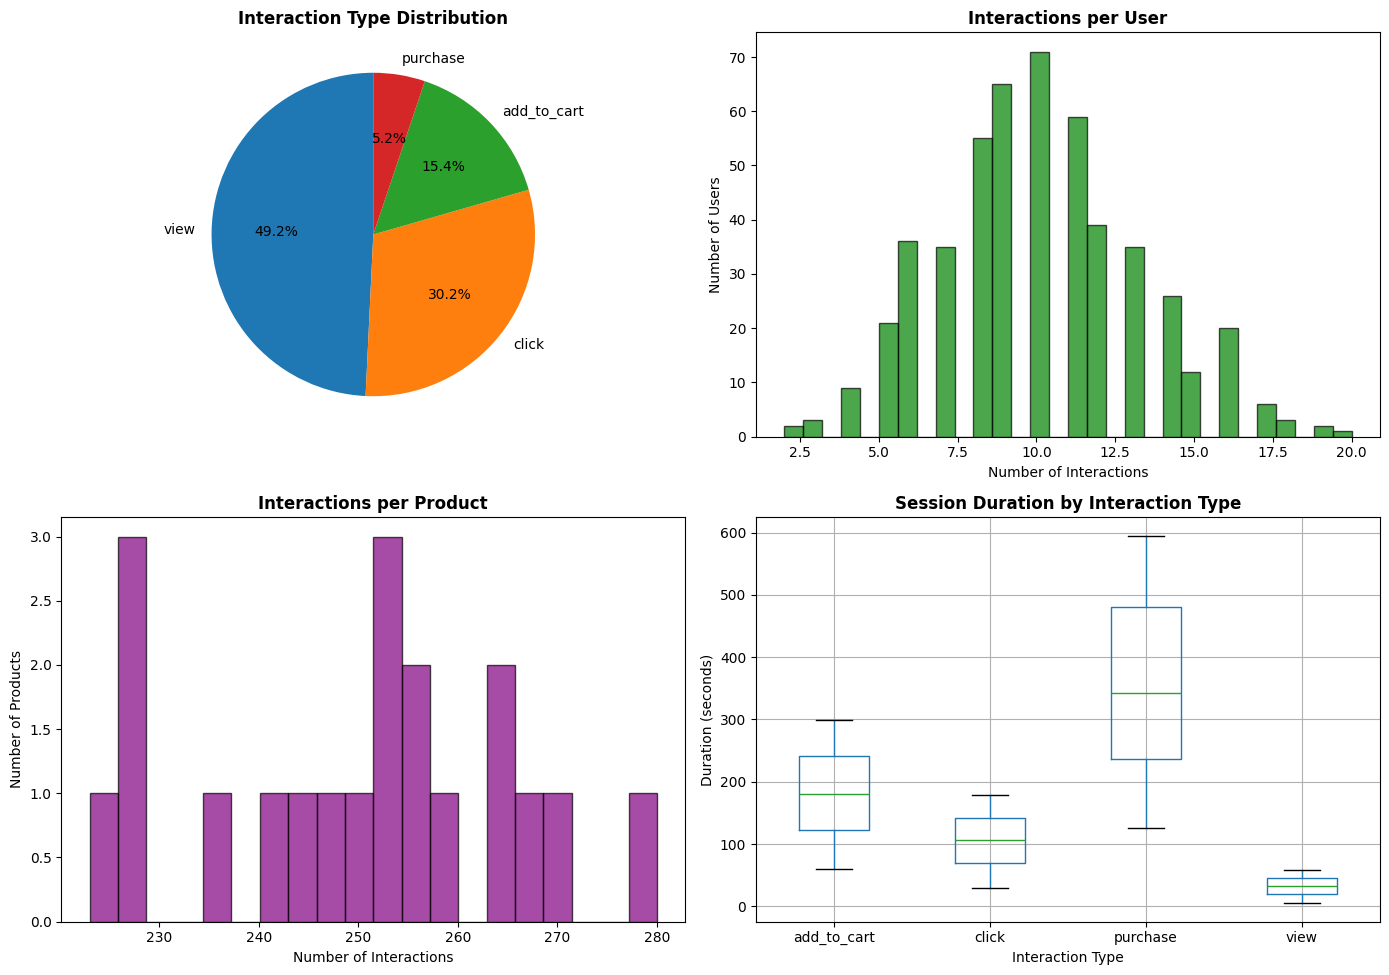

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Interaction type distribution
interaction_counts = df_interactions['interaction_type'].value_counts()
axes[0, 0].pie(interaction_counts.values, labels=interaction_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Interaction Type Distribution', fontsize=12, fontweight='bold')

# Interactions per user
user_interaction_counts = df_interactions['user_id'].value_counts()
axes[0, 1].hist(user_interaction_counts.values, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Interactions per User', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Interactions')
axes[0, 1].set_ylabel('Number of Users')

# Interactions per product
product_interaction_counts = df_interactions['product_id'].value_counts()
axes[1, 0].hist(product_interaction_counts.values, bins=20, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Interactions per Product', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Interactions')
axes[1, 0].set_ylabel('Number of Products')

# Session duration by interaction type
df_interactions.boxplot(column='duration_seconds', by='interaction_type', ax=axes[1, 1])
axes[1, 1].set_title('Session Duration by Interaction Type', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Interaction Type')
axes[1, 1].set_ylabel('Duration (seconds)')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [ ]:
n_users = df_interactions['user_id'].nunique()
n_products = df_interactions['product_id'].nunique()
n_interactions = len(df_interactions)

possible_interactions = n_users * n_products

sparsity = 1 - (n_interactions / possible_interactions)

print(f"\nNumber of Users: {n_users}")
print(f"Number of Products: {n_products}")
print(f"Total Interactions: {n_interactions}")
print(f"Possible Interactions: {possible_interactions:,}")
print(f"\nSparsity: {sparsity * 100:.2f}%")
print(f"Density: {(1 - sparsity) * 100:.2f}%")


Number of Users: 500
Number of Products: 20
Total Interactions: 5000
Possible Interactions: 10,000

Sparsity: 50.00%
Density: 50.00%
